# 1. Постановка гипотезы

Нужно определить, менять ли старую модель машинного обучения standard на новую svm_ensemble_v_1_22.
Посколько мы заранее не имеем представления о том, будет ли новая модель МО работать лучше или хуже чем текущий вариант модели, мы выбираем двусторонний статистический тест Two-Tailed Test
H0 : p = p0
H : p != p0
где p и p0 означают коэффициенты конверсии между новой и старой вариантами модели МО соответственно. Так же необходимо выбрать уровень доверия (confidence level). В нашем случае мы решили что это будет 95%. Имея уровень доверия в 95% необходимо рассчитать показатель альфа, который будет равен (1 - 0.95) для нашего теста = 0.05.

In [34]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.stats.api as sms
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil


# Настройки отображения графиков
%matplotlib inline

plt.style.use('seaborn-whitegrid')
font = {'family' : 'Helvetica',
        'weight' : 'bold',
        'size'   : 14}
mpl.rc('font', **font)

In [35]:
effect_size = sms.proportion_effectsize(0.13, 0.15)
# Cчитаем необходимый размер выборки -> https://www.statsmodels.org/dev/generated/statsmodels.stats.power.NormalIndPower.html?highlight=normalindpower
# https://www.statsmodels.org/dev/generated/statsmodels.stats.power.NormalIndPower.solve_power.html#statsmodels.stats.power.NormalIndPower.solve_power
required_n = sms.NormalIndPower().solve_power(effect_size, power=0.8, alpha=0.05, ratio=1) # Calculating sample size needed
# Округляем до ближайшего целого
required_n = ceil(required_n)
print("Для каждой группы нам необходимо не меньше ",required_n, " наблюдений")

Для каждой группы нам необходимо не меньше  4720  наблюдений


# 2. Сбор данных и их подготовка

In [36]:
df = pd.read_csv('./ab_test_inference/ab_test_ensembles.csv')
df.head(10)

,user_id,timestamp,group,variants,converted,location,age_group,user_type
0,9109b0dc-d393-497f-8d63-ba9a25dd16b4,2022-05-21 22:11:48.556739,control,standard,0,United Kingdom,18-25,registered_user
1,2430c3d2-f75b-4b31-8271-51b6a76c2652,2022-05-12 08:01:45.159739,control,standard,0,United Kingdom,42-49,registered_user
2,44788c4e-8dd2-4fad-b986-75e76f4adb64,2022-05-11 16:55:06.154213,treatment,svm_ensemble_v_1_22,0,United Kingdom,26-33,new_user
3,4699a417-506d-41b8-a354-6af6ad576963,2022-05-08 18:28:03.143765,treatment,svm_ensemble_v_1_22,0,United Kingdom,42-49,registered_user
4,304b0d28-bcdf-401a-9dff-66230d3ba0bc,2022-05-21 01:52:26.210827,control,standard,1,United Kingdom,42-49,registered_user
5,426f77eb-8739-43b6-999c-aecd14d9f346,2022-05-10 15:20:49.083499,control,standard,0,United Kingdom,42-49,registered_user
6,aa9d93c5-a18f-444a-a522-7e7145835362,2022-05-19 03:26:46.940749,treatment,svm_ensemble_v_1_22,1,United Kingdom,26-33,registered_user
7,de214e30-9b8d-44cf-87b1-16917f3e1c89,2022-05-17 01:48:29.539573,control,standard,0,United Kingdom,18-25,registered_user
8,070f398e-e6bf-43e7-88bb-37eff2cb9212,2022-05-04 17:58:08.979471,treatment,svm_ensemble_v_1_22,1,United Kingdom,18-25,new_user
9,9cff0b7e-d42b-4508-9fbe-a4e74f7f29c5,2022-05-15 18:11:06.610965,treatment,svm_ensemble_v_1_22,1,United Kingdom,26-33,new_user


In [37]:
pd.crosstab(df['group'], df['variants'])

variants,standard,svm_ensemble_v_1_22
group,,
control,145274,1928
treatment,1965,145311


In [38]:
#все пользователи уникальны
sessions = df['user_id'].value_counts(ascending=False)
duplicate_users = sessions[sessions > 1].count()
print(f"У нас имеются {duplicate_users} пользователей, которые не уникальны в нашей выборке.")

У нас имеются 0 пользователей, которые не уникальны в нашей выборке.


In [39]:
duplicate_users

0

In [41]:
control_sample = df[df['group'] == 'control'].sample(n = required_n, random_state=42)
treatment_sample = df[df['group'] == 'treatment'].sample(n = required_n, random_state=42)

# Сформируем общую случайную выборку
ab_df = pd.concat([control_sample, treatment_sample], axis=0)
ab_df.reset_index(drop=True, inplace=True)
ab_df.head()

,user_id,timestamp,group,variants,converted,location,age_group,user_type
0,bcf8452b-3056-4d45-994f-5f286fd9869a,2022-05-18 04:44:18.590293,control,standard,0,United Kingdom,42-49,new_user
1,3c827a98-0868-4ce5-ac31-8195e243af37,2022-05-14 05:22:43.771772,control,standard,0,United Kingdom,50-57,new_user
2,71c72bb9-13d9-4755-b398-b2c5d8b1c4d6,2022-05-23 08:52:53.050325,control,standard,0,United Kingdom,34-41,new_user
3,654ee878-b0c5-4223-b9fb-995ca3d2eaf1,2022-05-07 23:27:09.109877,control,standard,0,United Kingdom,26-33,registered_user
4,1e044366-7e86-4d92-bba7-3afaa6f887f8,2022-05-20 14:26:10.133979,control,standard,0,United Kingdom,42-49,new_user


In [42]:
ab_df.group.value_counts(normalize=True)

control      0.5
treatment    0.5
Name: group, dtype: float64

# 3. Визуализация результатов эксперимента

In [44]:
conversion_rates = ab_df.groupby('group')['converted']

# Стандартное отклонение для сформированной выборки
std_proportion = lambda x: np.std(x, ddof=0)
# Стандартная ошибка для сформированной выборки, формулу стандартной ошибки вы знаете из лекций. Забыли - погуглите.
se_proportion = lambda x: stats.sem(x, ddof=0)

conversion_rates = conversion_rates.agg([np.mean, std_proportion, se_proportion]).rename(columns={'mean':'CR mean', '<lambda_0>':'CR std', '<lambda_1>':'CR se'})
conversion_rates

,CR mean,CR std,CR se
group,,,
control,0.132415,0.338942,0.004933
treatment,0.119915,0.324862,0.004729


По выборочным статистикам два эксперимента +/- показывают себя одинаково, за исключением выборочного среднего коэффициента конверсии ~13.2% против ~11.9%
Выходит, что с моделью svm_ensemble_v_1_22 выборочный средний коэффициент конверсии даже ухудшается.

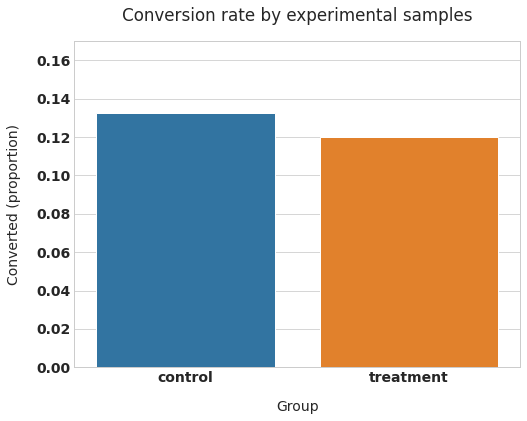

In [45]:
plt.figure(figsize=(8,6));
sns.barplot(x=ab_df['group'], y=ab_df['converted'], ci=False);
plt.ylim(0, 0.17);
plt.title('Conversion rate by experimental samples', pad=20)
plt.xlabel('Group', labelpad=15);
plt.ylabel('Converted (proportion)', labelpad=15);

# 4. Тестирование гипотезы

In [46]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

control_results = ab_df[ab_df['group'] == 'control']['converted']
treatment_results = ab_df[ab_df['group'] == 'treatment']['converted']

n_con = control_results.count()
n_treat = treatment_results.count()
successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'Z-statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'CI 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'CI 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

Z-statistic: 1.83
p-value: 0.067
CI 95% for control group: [0.123, 0.142]
CI 95% for treatment group: [0.111, 0.129]


# 5. Интерпретация результатов

Полученное p-значение = 0.067 выше выбранной альфы 0.05, поэтому согласно статистическому выводу, мы не можем отклонить нулевую гипотезу H0, что означает наша новая модель никак статистически значимо не влияет на уровень конверсии и понижение уровня конверсии - это случайность.
Доверительный интервал для испытуемой группы [0.11, 0.12] или 11% и 12% соответственно:
Он не включает наш baseline
Он не достигает нашей цели 15%

Ответы на вопросы:
1. Лучше оставить старый вариант работы модели

# Проверка гипотезы для пользователей разных типов.
# User type: New

In [47]:
#отбираем новых пользователей как целевую группу
df_new_users=df[df['user_type']=='new_user']
df_new_users.shape

(147238, 8)

In [48]:
#среди них случайным образом выбираем control и treatment погруппы
control_sample = df_new_users[df_new_users['group'] == 'control'].sample(n = required_n, random_state=42)
treatment_sample = df_new_users[df_new_users['group'] == 'treatment'].sample(n = required_n, random_state=42)

# Сформируем общую случайную выборку для новых юзеров
ab_df_new_users = pd.concat([control_sample, treatment_sample], axis=0)
ab_df_new_users.reset_index(drop=True, inplace=True)
ab_df_new_users.head()

,user_id,timestamp,group,variants,converted,location,age_group,user_type
0,36c2884d-9846-4553-a37f-fa36ce50cb45,2022-05-04 09:13:11.837377,control,standard,0,United Kingdom,34-41,new_user
1,58b4787c-15a1-4fc9-b1b6-a3b61e68e272,2022-05-22 14:59:41.304326,control,standard,1,United Kingdom,18-25,new_user
2,032e7ad0-0822-43c3-bb67-a96b6a52cc52,2022-05-02 17:33:23.178911,control,standard,0,United Kingdom,50-57,new_user
3,05676ce3-4498-47f3-a3f4-56fd04785318,2022-05-11 14:59:29.033575,control,standard,0,United Kingdom,34-41,new_user
4,b696f64f-f2a4-4878-9f22-c53aa82e092a,2022-05-22 05:59:01.010862,control,standard,0,United Kingdom,58+,new_user


In [52]:
ab_df_new_users.group.value_counts(normalize=True)

control      0.5
treatment    0.5
Name: group, dtype: float64

In [56]:
conversion_rates = ab_df_new_users.groupby('group')['converted']
# Стандартное отклонение для сформированной выборки
std_proportion = lambda x: np.std(x, ddof=0)
# Стандартная ошибка для сформированной выборки, формулу стандартной ошибки вы знаете из лекций. Забыли - погуглите.
se_proportion = lambda x: stats.sem(x, ddof=0)

conversion_rates = conversion_rates.agg([np.mean, std_proportion, se_proportion]).rename(
        columns={'mean': 'CR mean', '<lambda_0>': 'CR std', '<lambda_1>': 'CR se'})
conversion_rates

,CR mean,CR std,CR se
group,,,
control,0.122034,0.327325,0.004764
treatment,0.127331,0.333343,0.004852


По выборочным статистикам для новых пользователей два эксперимента +/- показывают себя примерно одинаково.

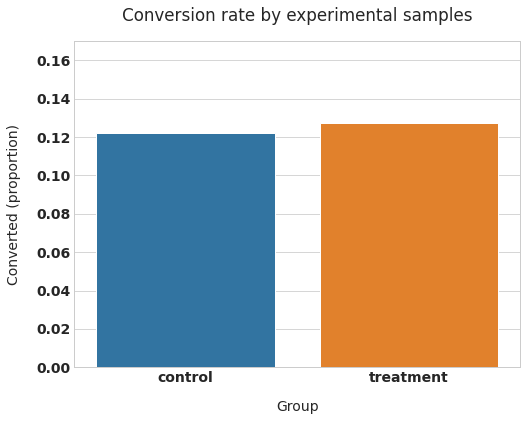

In [57]:
plt.figure(figsize=(8,6));
sns.barplot(x=ab_df_new_users['group'], y=ab_df_new_users['converted'], ci=False);
plt.ylim(0, 0.17);
plt.title('Conversion rate by experimental samples', pad=20)
plt.xlabel('Group', labelpad=15);
plt.ylabel('Converted (proportion)', labelpad=15);

In [58]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

control_results = ab_df_new_users[ab_df_new_users['group'] == 'control']['converted']
treatment_results = ab_df_new_users[ab_df_new_users['group'] == 'treatment']['converted']

n_con = control_results.count()
n_treat = treatment_results.count()
successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'Z-statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'CI 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'CI 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

Z-statistic: -0.78
p-value: 0.436
CI 95% for control group: [0.113, 0.131]
CI 95% for treatment group: [0.118, 0.137]


Полученное p-значение = 0.436 значительно выше выбранной альфы 0.05, поэтому согласно статистическому выводу, мы не можем отклонить нулевую гипотезу H0, что означает наша новая модель никак статистически значимо не влияет на уровень конверсии и понижение уровня конверсии - это случайность. Доверительный интервал для испытуемой группы [0.11, 0.13] или 11% и 13% соответственно: Он включает наш baseline, но не достигает нашей цели 15%

Ответ: по группе новых пользователей также не стоит менять старую модель.

# Проверка гипотезы для старых пользователей
# User Type: Registered users

In [60]:
#отбираем зарегестрированных пользователей как целевую группу
df_reg_users=df[df['user_type']=='registered_user']
df_reg_users.shape

(147240, 8)

In [61]:
#среди них случайным образом выбираем control и treatment погруппы
control_sample = df_reg_users[df_reg_users['group'] == 'control'].sample(n = required_n, random_state=42)
treatment_sample = df_reg_users[df_reg_users['group'] == 'treatment'].sample(n = required_n, random_state=42)

# Сформируем общую случайную выборку для новых юзеров
ab_df_reg_users = pd.concat([control_sample, treatment_sample], axis=0)
ab_df_reg_users.reset_index(drop=True, inplace=True)
ab_df_reg_users.head()

,user_id,timestamp,group,variants,converted,location,age_group,user_type
0,3960d256-ab06-4282-b1bb-1f84a0ad27f4,2022-05-09 10:12:05.412405,control,standard,1,United Kingdom,34-41,registered_user
1,e6d3713e-1f4a-4cab-8186-de2c5bc3c799,2022-05-19 08:49:58.838873,control,standard,0,United Kingdom,26-33,registered_user
2,e4270216-3f3d-4f9e-b615-621709a42625,2022-05-20 20:55:27.488474,control,standard,0,United Kingdom,42-49,registered_user
3,32802f77-5b12-4a02-ad78-d310496ebaea,2022-05-06 14:03:09.808327,control,standard,0,United Kingdom,58+,registered_user
4,e3ea432a-2313-47b0-977d-d2947061bdde,2022-05-04 03:42:37.266315,control,standard,0,United Kingdom,58+,registered_user


In [62]:
ab_df_reg_users.group.value_counts(normalize=True)
conversion_rates = ab_df_reg_users.groupby('group')['converted']
# Стандартное отклонение для сформированной выборки
std_proportion = lambda x: np.std(x, ddof=0)
# Стандартная ошибка для сформированной выборки, формулу стандартной ошибки вы знаете из лекций. Забыли - погуглите.
se_proportion = lambda x: stats.sem(x, ddof=0)

conversion_rates = conversion_rates.agg([np.mean, std_proportion, se_proportion]).rename(
        columns={'mean': 'CR mean', '<lambda_0>': 'CR std', '<lambda_1>': 'CR se'})
conversion_rates

,CR mean,CR std,CR se
group,,,
control,0.121398,0.326590,0.004754
treatment,0.119280,0.324117,0.004718


По выборочным статистикам для новых пользователей два эксперимента +/- показывают себя примерно одинаково.

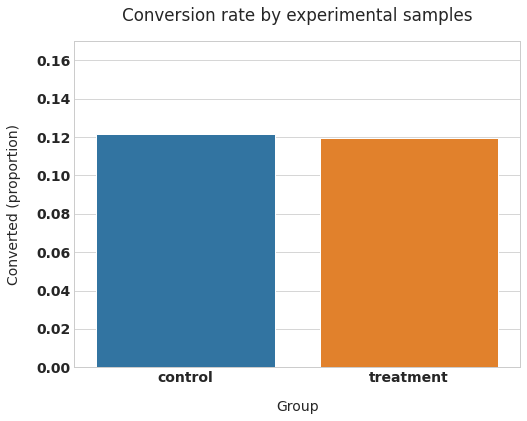

In [65]:
plt.figure(figsize=(8, 6));
sns.barplot(x=ab_df_reg_users['group'], y=ab_df_reg_users['converted'], ci=False);
plt.ylim(0, 0.17);
plt.title('Conversion rate by experimental samples', pad=20)
plt.xlabel('Group', labelpad=15);
plt.ylabel('Converted (proportion)', labelpad=15);

In [66]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

control_results = ab_df_reg_users[ab_df_reg_users['group'] == 'control']['converted']
treatment_results = ab_df_reg_users[ab_df_reg_users['group'] == 'treatment']['converted']

n_con = control_results.count()
n_treat = treatment_results.count()
successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'Z-statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'CI 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'CI 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

Z-statistic: 0.32
p-value: 0.752
CI 95% for control group: [0.112, 0.131]
CI 95% for treatment group: [0.110, 0.129]


Полученное p-значение = 0.752 так же значительно выше выбранной альфы 0.05, поэтому согласно статистическому выводу, мы не можем отклонить нулевую гипотезу H0, что означает наша новая модель никак статистически значимо не влияет на уровень конверсии и понижение уровня конверсии - это случайность. Доверительный интервал для испытуемой группы [0.11, 0.12] или 11% и 12% соответственно: Он не включает наш baseline и не достигает нашей цели 15%

Ответ: по группе зарегистрированных пользователей также не стоит менять старую модель.

2. Итого ни для новых, ни для старых пользователей не стоит менять старую модель.